This is Will's edit of a notebook originally written by Javier.

# Correlations between H II region parameters

We look at correlations between 6 principal measurements that fall into two groups: 

* Basic parameters: 
    * Size: $S$
    * Ionizing luminosity: $L(\mathrm{H\alpha})$
    * Distance: $d$
    * Velocity dispersion on line of sigth: $\sigma_{\text{los}}$
* Velocity structure function parameters:
    * Velocity dispersion on plane of sky: $\sigma_{\text{pos}}$
    * Velocity autocorrelation length scale: $r_0$
    * Structure function slope in inertial range: $m$

In [1]:
from pathlib import Path


import time
start_time=time.time()
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
import lmfit
import statsmodels.api as sm
import linmix
from scipy.stats import pearsonr
import pickle
import math
import itertools
import json
from logerr import logify



Load Table with physical properties

In [2]:
physical_data = pd.read_table('property-regions-data.csv', delimiter=',')
#physical_data = physical_data.drop(physical_data .index[[5,7]])

Path names

In [3]:
datapath_names = Path(open("path-name-list.txt", "r").read()).expanduser()

In [4]:
samples=pd.read_csv(str(datapath_names) +'//sample-names-corr.csv',header=None)
Names=pd.read_csv(str(datapath_names) +'//formal-names-corr.csv',header=None)

Load Results

In [5]:
datapath_res = Path(open("path-results.txt", "r").read()).expanduser()

In [6]:
data = {}
Results = {}

for i in range(len(samples)):
    data[samples[0][i]] = json.load(open(str(datapath_res) + '/' + samples[0][i] + ".json"))

In [7]:
#sigma
sig = [[0]*(1) for i in range(len(samples))]
siger = [[0]*(1) for i in range(len(samples))]

#velocity dispersion with 2-sig intervals
sig2 = [[0]*(1) for i in range(len(samples))]
#sig2er = [[0]*(1) for i in range(len(samples))]
sig2s2 = [[0]*(1) for i in range(len(samples))]
sig2s2p = [[0]*(1) for i in range(len(samples))]
sig2s2m = [[0]*(1) for i in range(len(samples))]

#correlation length with 2-sig intervals
r0 = [[0]*(1) for i in range(len(samples))]
#r0er = [[0]*(1) for i in range(len(samples))]
r0s2 = [[0]*(1) for i in range(len(samples))]
r0s2p = [[0]*(1) for i in range(len(samples))]
r0s2m = [[0]*(1) for i in range(len(samples))]

#power-law
m = [[0]*(1) for i in range(len(samples))]
#mer = [[0]*(1) for i in range(len(samples))]
ms2 = [[0]*(1) for i in range(len(samples))]
ms2p = [[0]*(1) for i in range(len(samples))]
ms2m = [[0]*(1) for i in range(len(samples))]

#noise with 2-sig intervals
bn = [[0]*(1) for i in range(len(samples))]
#ner = [[0]*(1) for i in range(len(samples))]
bns2 = [[0]*(1) for i in range(len(samples))]
bns2p = [[0]*(1) for i in range(len(samples))]
bns2m = [[0]*(1) for i in range(len(samples))]

#seeing with 2-sig intervals
s0 = [[0]*(1) for i in range(len(samples))]
#s0er = [[0]*(1) for i in range(len(samples))]
s0s2 = [[0]*(1) for i in range(len(samples))]
s0s2p = [[0]*(1) for i in range(len(samples))]
s0s2m = [[0]*(1) for i in range(len(samples))]

pc = [[0]*(1) for i in range(len(samples))]
box_size = [[0]*(1) for i in range(len(samples))]

In [8]:
for i in range(len(samples)):    
    
    sig2[i] = data[samples[0][i]]['results_2sig']['sig2'][0]
    sig2s2p[i] = data[samples[0][i]]['results_2sig']['sig2'][1]
    sig2s2m[i] = data[samples[0][i]]['results_2sig']['sig2'][2]
    
    r0[i]    = data[samples[0][i]]['results_2sig']['r0'][0]
    r0s2p[i] = data[samples[0][i]]['results_2sig']['r0'][1]
    r0s2m[i] = data[samples[0][i]]['results_2sig']['r0'][2]
    
    m[i]    = data[samples[0][i]]['results_2sig']['m'][0]
    ms2p[i] = data[samples[0][i]]['results_2sig']['m'][1]
    ms2m[i] = data[samples[0][i]]['results_2sig']['m'][2]
    
    bn[i]    = data[samples[0][i]]['results_2sig']['noise'][0]
    bns2p[i] = data[samples[0][i]]['results_2sig']['noise'][1]
    bns2m[i] = data[samples[0][i]]['results_2sig']['noise'][2]
    
    s0[i]    = data[samples[0][i]]['results_2sig']['s0'][0]
    s0s2p[i] = data[samples[0][i]]['results_2sig']['s0'][1]
    s0s2m[i] = data[samples[0][i]]['results_2sig']['s0'][2]
    
    box_size[i] = data[samples[0][i]]['properties']['box_size']
    pc[i] = data[samples[0][i]]['properties']['pc']

In [9]:
s0f = pd.DataFrame(
    {
        "s0 [RMS]":s0,
        "s0+[RMS]": s0s2p,
        "s0-[RMS]": s0s2m,  
       "s0 [FWHM]": np.array(s0)*2.35/np.array(pc),
       "s0- [FWHM]": np.array(s0s2m)*2.35/np.array(pc),
       "s0+ [FWHM]": np.array(s0s2p)*2.35/np.array(pc),
        "bn ":bn,
        "bn+": bns2p,
        "bn- ": bns2m,     
    }
)

s0f.insert(loc=0, column='Region', value=Names)


s0f.round(4)

,Region,s0 [RMS],s0+[RMS],s0-[RMS],s0 [FWHM],s0- [FWHM],s0+ [FWHM],bn,bn+,bn-
0,NGC 604,2.1078,1.0353,0.7852,1.2163,0.4531,0.5974,0.3275,0.7014,0.3071
1,NGC 595,0.4072,0.6191,-0.0056,0.2350,-0.0032,0.3573,1.5372,1.7052,1.0506
2,Hubble X,0.3624,0.3295,0.1063,0.3513,0.1030,0.3194,0.3211,0.4153,0.2794
3,Hubble V,0.3412,0.5341,0.0602,0.3307,0.0584,0.5177,0.0000,0.6539,-0.0098
4,30 Dor,0.1577,0.0874,0.0452,1.5288,0.4383,0.8477,6.1556,1.5788,1.5700
5,Carina,0.0075,0.0076,0.0061,1.7042,1.3811,1.7389,2.2569,2.4231,1.9776
6,NGC 346,0.1115,0.0266,0.0182,0.8718,0.1422,0.2080,0.8402,0.0701,0.0694
7,M8,0.0070,0.0019,0.0062,2.7083,2.3923,0.7335,0.4367,0.2088,0.3035
8,Orion,0.0020,0.0003,0.0002,2.3995,0.2473,0.3104,0.0252,0.0049,0.0049


In [10]:
s1f = pd.DataFrame(
    {
        "sig2":sig2,
        "sig2+": sig2s2p,
        "sig2-": sig2s2m,
        "r0":r0,
        "r0+": r0s2p,
        "r0-": r0s2m,
        "m":m,
        "m+": ms2p,
        "m-": ms2m,
       
    }
)

s1f.insert(loc=0, column='Region', value=Names)


s1f.round(4)

,Region,sig2,sig2+,sig2-,r0,r0+,r0-,m,m+,m-
0,NGC 604,85.8687,20.4180,11.4636,12.0876,6.4431,3.9551,0.7751,0.2074,0.2267
1,NGC 595,53.2064,4.6434,1.9165,11.2117,0.7392,0.8512,1.3764,0.0880,0.1493
2,Hubble X,14.8123,2.6723,0.6829,4.0994,0.3259,0.1877,1.0161,0.0806,0.2222
3,Hubble V,9.8240,3.5344,0.5024,3.5620,0.4514,1.2700,0.8104,0.0933,0.2830
4,30 Dor,297.5367,39.6113,18.5188,3.8579,1.0645,0.4682,0.8520,0.0778,0.1389
5,Carina,18.1376,1.3939,1.5275,0.5505,0.0822,0.0659,1.1584,0.2763,0.1749
6,NGC 346,33.0228,2.5681,1.4874,2.3737,0.2938,0.1596,0.9564,0.0478,0.0708
7,M8,7.3852,1.2428,0.7439,1.0347,0.2365,0.1228,1.2639,0.1764,0.1929
8,Orion,12.6480,0.7428,0.5220,0.0680,0.0061,0.0041,1.0734,0.0312,0.0390


In [11]:
physical_data

,Region,LHa,LHaer,SFR,n,L [pc],Ler [pc],Dist [kpc],Dister [kpc],siglos [km/s],sigloser [km/s],Diam [pc],Diamer [pc]
0,NGC 604,2.630000e+39,2.630000e+38,0.005300,0.35,400,40.0,840.00,30.00,17.51,0.30,400,40.0
1,NGC 595,8.910000e+38,8.910000e+37,0.002600,1.66,400,40.0,840.00,30.00,16.52,0.09,400,40.0
2,Hubble X,1.620000e+38,1.620000e+37,0.000310,0.35,160,16.0,500.00,40.00,10.00,0.02,160,16.0
3,Hubble V,1.990000e+38,1.990000e+37,0.000150,0.11,130,13.0,500.00,40.00,9.79,0.03,130,13.0
4,30Dor,2.930000e+39,2.930000e+38,0.013000,6.16,370,37.0,50.00,0.19,21.77,2.20,370,37.0
5,Carina,1.020000e+39,1.020000e+38,0.010000,2.26,200,20.0,2.35,0.05,18.60,3.30,200,20.0
6,NGC 346,6.000000e+38,6.000000e+37,0.002100,1.20,220,22.0,61.70,1.10,9.58,1.00,220,22.0
7,M8,3.000000e+37,3.000000e+36,0.000100,0.44,25,2.5,1.25,0.10,11.25,1.60,25,2.5
8,OrionS,1.510000e+37,1.510000e+36,0.000053,0.03,5,0.5,0.40,0.02,9.90,1.20,5,0.5


In [12]:
data = pd.DataFrame(
    {
       "Region": physical_data.Region,
       "LHa": physical_data.LHa,
       "LHaer": physical_data.LHaer,
       "SFR": physical_data.SFR,
       "n": physical_data.n,
       "L [pc]": physical_data['Diam [pc]'],
       "Ler [pc]": physical_data['Diamer [pc]'],
       "Dist [kpc]": physical_data['Dist [kpc]'],
       "Dister [kpc]": physical_data['Dister [kpc]'],
        
       "sig2 [km/s]": sig2,
       "sig2er": sig2s2p,
        "sig [km/s]": np.array(sig2)**0.5,
       "siger": np.array(sig2s2p)**0.5,
        "m": m,
       "mer": ms2p,
       "r0 [pc]": r0,
       "r0er": r0s2p,
        
       "siglos [km/s]": physical_data['siglos [km/s]'],
       "sigloser [km/s]": physical_data['sigloser [km/s]'],
      
    },
)

In [13]:
data.dtypes

Region              object
LHa                float64
LHaer              float64
SFR                float64
n                  float64
L [pc]               int64
Ler [pc]           float64
Dist [kpc]         float64
Dister [kpc]       float64
sig2 [km/s]        float64
sig2er             float64
sig [km/s]         float64
siger              float64
m                  float64
mer                float64
r0 [pc]            float64
r0er               float64
siglos [km/s]      float64
sigloser [km/s]    float64
dtype: object

In [14]:
data.round(4)

,Region,LHa,LHaer,SFR,n,L [pc],Ler [pc],Dist [kpc],Dister [kpc],sig2 [km/s],sig2er,sig [km/s],siger,m,mer,r0 [pc],r0er,siglos [km/s],sigloser [km/s]
0,NGC 604,2.630000e+39,2.630000e+38,0.0053,0.35,400,40.0,840.00,30.00,85.8687,20.4180,9.2665,4.5186,0.7751,0.2074,12.0876,6.4431,17.51,0.30
1,NGC 595,8.910000e+38,8.910000e+37,0.0026,1.66,400,40.0,840.00,30.00,53.2064,4.6434,7.2943,2.1548,1.3764,0.0880,11.2117,0.7392,16.52,0.09
2,Hubble X,1.620000e+38,1.620000e+37,0.0003,0.35,160,16.0,500.00,40.00,14.8123,2.6723,3.8487,1.6347,1.0161,0.0806,4.0994,0.3259,10.00,0.02
3,Hubble V,1.990000e+38,1.990000e+37,0.0001,0.11,130,13.0,500.00,40.00,9.8240,3.5344,3.1343,1.8800,0.8104,0.0933,3.5620,0.4514,9.79,0.03
4,30Dor,2.930000e+39,2.930000e+38,0.0130,6.16,370,37.0,50.00,0.19,297.5367,39.6113,17.2493,6.2938,0.8520,0.0778,3.8579,1.0645,21.77,2.20
5,Carina,1.020000e+39,1.020000e+38,0.0100,2.26,200,20.0,2.35,0.05,18.1376,1.3939,4.2588,1.1806,1.1584,0.2763,0.5505,0.0822,18.60,3.30
6,NGC 346,6.000000e+38,6.000000e+37,0.0021,1.20,220,22.0,61.70,1.10,33.0228,2.5681,5.7465,1.6025,0.9564,0.0478,2.3737,0.2938,9.58,1.00
7,M8,3.000000e+37,3.000000e+36,0.0001,0.44,25,2.5,1.25,0.10,7.3852,1.2428,2.7176,1.1148,1.2639,0.1764,1.0347,0.2365,11.25,1.60
8,OrionS,1.510000e+37,1.510000e+36,0.0001,0.03,5,0.5,0.40,0.02,12.6480,0.7428,3.5564,0.8619,1.0734,0.0312,0.0680,0.0061,9.90,1.20


In [15]:
cols = data.columns
logdata = data.copy()
for col in cols:
    if col not in ["Region", "m", "mer", "r0er", "siger",  "sig2er", "Ler [pc]", "Dister [kpc]","LHaer","sigloser [km/s]"]:
        logdata[col] = np.round(np.log10(logdata[col]), 2)
        logdata.rename(columns={col: f"log {col}"}, inplace=True)
# Some minor changes to column names
logdata.rename(
    columns={
        "log LHa": "log L(H) [erg s^-1]",
        }, 
    inplace=True)
logdata

,Region,log L(H) [erg s^-1],LHaer,log SFR,log n,log L [pc],Ler [pc],log Dist [kpc],Dister [kpc],log sig2 [km/s],sig2er,log sig [km/s],siger,m,mer,log r0 [pc],r0er,log siglos [km/s],sigloser [km/s]
0,NGC 604,39.42,2.630000e+38,-2.28,-0.46,2.60,40.0,2.92,30.00,1.93,20.418004,0.97,4.518629,0.775075,0.207397,1.08,6.443078,1.24,0.30
1,NGC 595,38.95,8.910000e+37,-2.59,0.22,2.60,40.0,2.92,30.00,1.73,4.643371,0.86,2.154848,1.376368,0.087961,1.05,0.739236,1.22,0.09
2,Hubble X,38.21,1.620000e+37,-3.51,-0.46,2.20,16.0,2.70,40.00,1.17,2.672278,0.59,1.634710,1.016097,0.080615,0.61,0.325858,1.00,0.02
3,Hubble V,38.30,1.990000e+37,-3.82,-0.96,2.11,13.0,2.70,40.00,0.99,3.534439,0.50,1.880010,0.810433,0.093346,0.55,0.451416,0.99,0.03
4,30Dor,39.47,2.930000e+38,-1.89,0.79,2.57,37.0,1.70,0.19,2.47,39.611347,1.24,6.293755,0.851961,0.077782,0.59,1.064497,1.34,2.20
5,Carina,39.01,1.020000e+38,-2.00,0.35,2.30,20.0,0.37,0.05,1.26,1.393893,0.63,1.180632,1.158353,0.276279,-0.26,0.082150,1.27,3.30
6,NGC 346,38.78,6.000000e+37,-2.68,0.08,2.34,22.0,1.79,1.10,1.52,2.568073,0.76,1.602521,0.956389,0.047801,0.38,0.293811,0.98,1.00
7,M8,37.48,3.000000e+36,-4.00,-0.36,1.40,2.5,0.10,0.10,0.87,1.242835,0.43,1.114825,1.263906,0.176361,0.01,0.236500,1.05,1.60
8,OrionS,37.18,1.510000e+36,-4.28,-1.52,0.70,0.5,-0.40,0.02,1.10,0.742833,0.55,0.861878,1.073374,0.031151,-1.17,0.006121,1.00,1.20


Uncertainties Log Space

In [16]:
logdata['Ler [pc]']=(data['Ler [pc]']/data['L [pc]'])*0.434
logdata['sigloser [km/s]']=(data['sigloser [km/s]']/data['siglos [km/s]'])*0.434
logdata['LHaer']=(data['LHaer']/data['LHa'])*0.434
logdata['Dister [kpc]']=(data['Dister [kpc]']/data['Dist [kpc]'])*0.434
logdata['mer']=(data['mer']/data['m'])*0.434
logdata['r0er']=(data['r0er']/data['r0 [pc]'])*0.434
logdata['siger']=(data['siger']/data['sig [km/s]'])*0.434
logdata['sig2er']=(data['sig2er']/data['sig2 [km/s]'])*0.434

In [17]:
#logify(data['L [pc]'],data['Ler [pc]'])

Make the label text bigger on the figures

In [18]:
sns.set_context("talk")

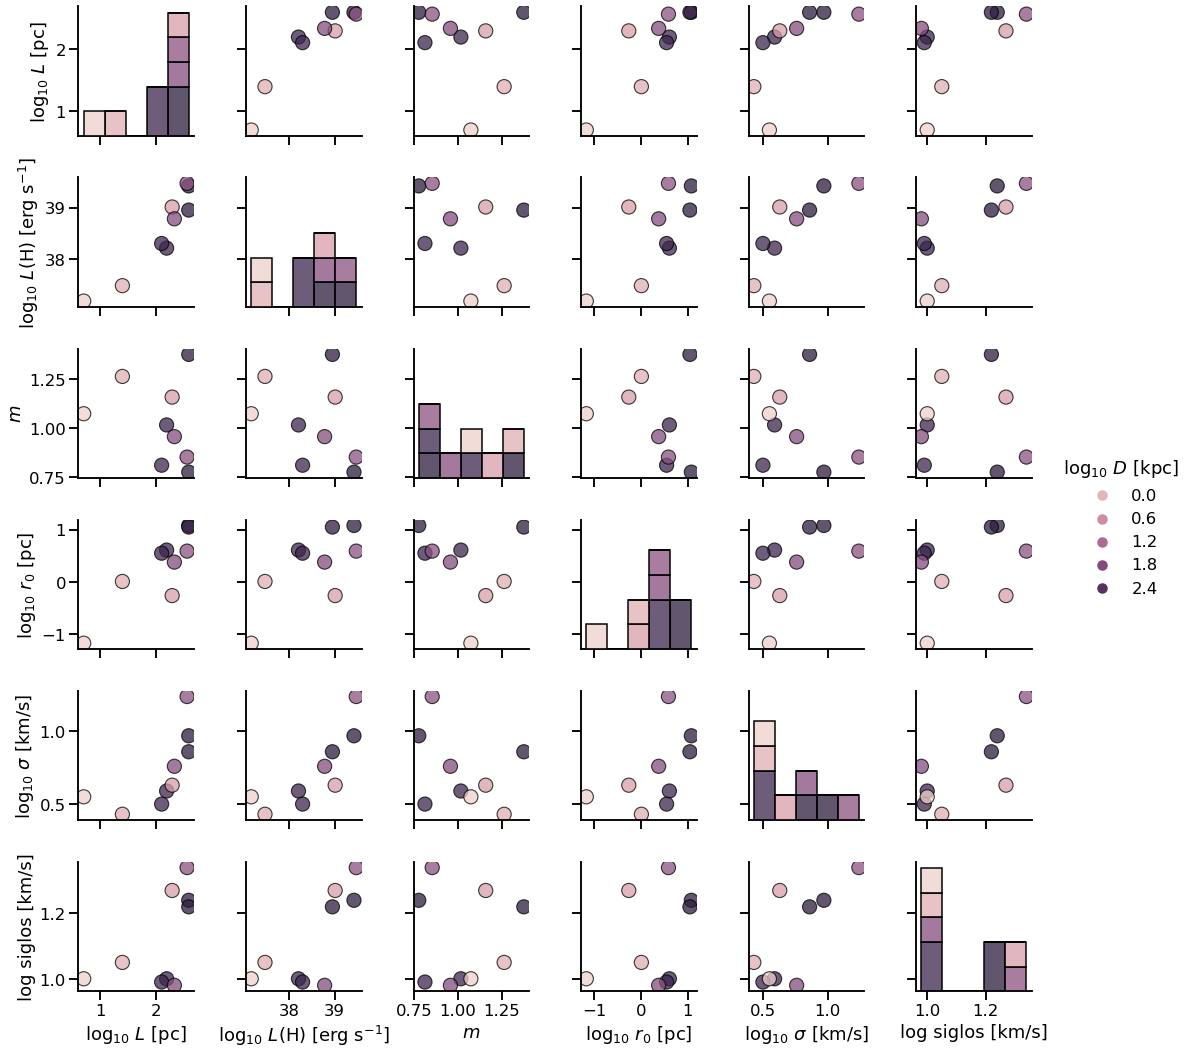

In [19]:
selected_vars = [ "log L [pc]","log L(H) [erg s^-1]", "log Dist [kpc]", "m", "log r0 [pc]", "log sig [km/s]", "log siglos [km/s]"]
plotdata = logdata[selected_vars].rename(
    columns={
        # Switch column names to use latex formatting to improve axis labels
        "log L [pc]": r"$\log_{10}\ L$ [pc]", 
        "log L(H) [erg s^-1]": r"$\log_{10}\ L(\mathrm{H})$ [erg s$^{-1}$]", 
        "m": "$m$", 
        "log r0 [pc]": r"$\log_{10}\ r_0$ [pc]", 
        "log sig [km/s]": r"$\log_{10}\ \sigma$ [km/s]", 
        "log Dist [kpc]": r"$\log_{10}\ D$ [kpc]",
    },
)

sns.pairplot(plotdata, 
             hue=r"$\log_{10}\ D$ [kpc]",
             plot_kws=dict(alpha=0.75, s=200, edgecolor="k"), 
             diag_kind='hist',
             diag_kws= dict(multiple='stack'),
             );

figname = "strucfunc-correlations"
# Save PDF and JPG versions of the figure
#plt.gcf().savefig(f"{figname}.pdf")
#plt.gcf().savefig(f"{figname}.jpg")

## Comparion previous work



In [20]:
path_previous = 'data-previous-scaling-relations'

In [21]:
Moiseev=pd.read_csv(path_previous+'//Moiseev2015.csv')
Ostin=pd.read_csv(path_previous+'//Ostin2001.csv')
Blasco=pd.read_csv(path_previous+'//Blasco2013.csv')
Rozas=pd.read_csv(path_previous+'//Rozas2006.csv')
Ars=pd.read_csv(path_previous+'//ArsRoy1986.csv')
Wis=pd.read_csv(path_previous+'//Wis2012.csv')
Gal=pd.read_csv(path_previous+'//Gallagher1983.csv')
Fer=pd.read_csv(path_previous+'//Fernandez2018.csv')



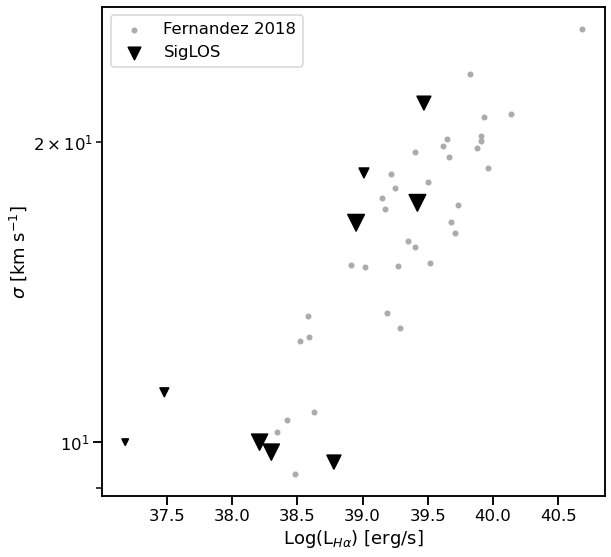

In [22]:
fig, ax=plt.subplots(figsize=(9,9))

plt.scatter(Fer.L,10**(Fer.sig),label='Fernandez 2018',marker='.',alpha=0.95,color='darkgray')

#plt.scatter(logdata['log L(H) [erg s^-1]'],10**(logdata['log sig [km/s]']),marker='o',label='SigPOS',color='black',s=(logdata['log Dist [kpc]']+1.0)*70)
plt.scatter(logdata['log L(H) [erg s^-1]'],10**(logdata['log siglos [km/s]']),marker='v',label='SigLOS',color='black',s=(logdata['log Dist [kpc]']+1.0)*70)

plt.yscale('log')

ax.set(
#    ylim  = [36, 43],
#    xlim  = [1, 150],
)
#ax.set_facecolor('whitesmoke')
ax.set(xlabel='Log(L$_{Hα}$) [erg/s]', ylabel='$σ$ [km s$^{-1}$]')
plt.legend()
#fig.savefig('SFplots//lvss.pdf', bbox_inches='tight')

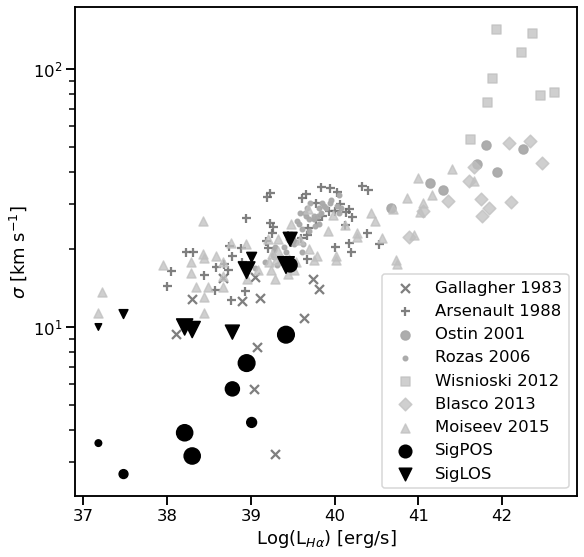

In [23]:


fig, ax=plt.subplots(figsize=(9,9))

plt.scatter(Gal.L,Gal.sig,label='Gallagher 1983',marker='x',alpha=0.85,color='dimgray')
plt.scatter(Ars.L,10**Ars.sig,label='Arsenault 1988',marker='+',alpha=0.85,color='dimgray')
plt.scatter(Ostin.L,Ostin.sig,label='Ostin 2001',marker='o',alpha=0.95,color='darkgray')
plt.scatter(Rozas.L,10**(Rozas.sig),label='Rozas 2006',marker='.',alpha=0.95,color='darkgray')
plt.scatter(Wis.L,Wis.sig,label='Wisnioski 2012',marker='s',alpha=0.75,color='silver')
plt.scatter(Blasco.L,Blasco.sig,label='Blasco 2013',marker='D',alpha=0.75,color='silver')
plt.scatter(Moiseev.L,Moiseev.sig,label='Moiseev 2015',marker='^',alpha=0.75,color='silver')

plt.scatter(logdata['log L(H) [erg s^-1]'],10**(logdata['log sig [km/s]']),marker='o',label='SigPOS',color='black',s=(logdata['log Dist [kpc]']+1.0)*70)
plt.scatter(logdata['log L(H) [erg s^-1]'],10**(logdata['log siglos [km/s]']),marker='v',label='SigLOS',color='black',s=(logdata['log Dist [kpc]']+1.0)*70)

plt.yscale('log')

ax.set(
#    ylim  = [36, 43],
#    xlim  = [1, 150],
)
#ax.set_facecolor('whitesmoke')
ax.set(xlabel='Log(L$_{Hα}$) [erg/s]', ylabel='$σ$ [km s$^{-1}$]')
plt.legend()
#fig.savefig('SFplots//lvss.pdf', bbox_inches='tight')



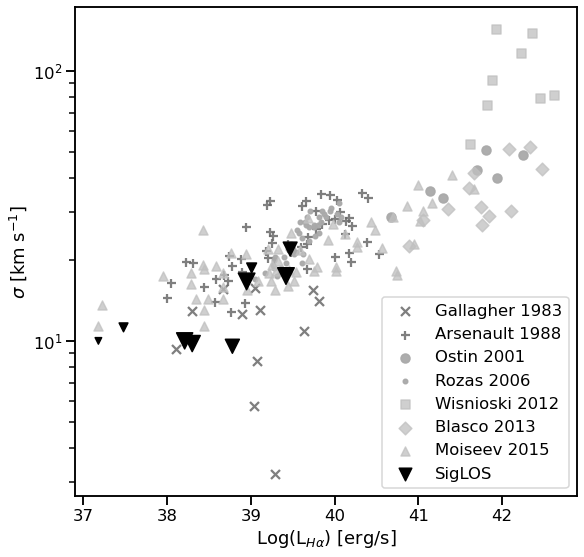

In [24]:
fig, ax=plt.subplots(figsize=(9,9))

plt.scatter(Gal.L,Gal.sig,label='Gallagher 1983',marker='x',alpha=0.85,color='dimgray')
plt.scatter(Ars.L,10**Ars.sig,label='Arsenault 1988',marker='+',alpha=0.85,color='dimgray')
plt.scatter(Ostin.L,Ostin.sig,label='Ostin 2001',marker='o',alpha=0.95,color='darkgray')
plt.scatter(Rozas.L,10**(Rozas.sig),label='Rozas 2006',marker='.',alpha=0.95,color='darkgray')
plt.scatter(Wis.L,Wis.sig,label='Wisnioski 2012',marker='s',alpha=0.75,color='silver')
plt.scatter(Blasco.L,Blasco.sig,label='Blasco 2013',marker='D',alpha=0.75,color='silver')
plt.scatter(Moiseev.L,Moiseev.sig,label='Moiseev 2015',marker='^',alpha=0.75,color='silver')

#plt.scatter(logdata['log L(H) [erg s^-1]'],10**(logdata['log sig [km/s]']),marker='o',label='SigPOS',color='black',s=(logdata['log Dist [kpc]']+1.0)*70)
plt.scatter(logdata['log L(H) [erg s^-1]'],10**(logdata['log siglos [km/s]']),marker='v',label='SigLOS',color='black',s=(logdata['log Dist [kpc]']+1.0)*70)

plt.yscale('log')

ax.set(
#    ylim  = [36, 43],
#    xlim  = [1, 150],
)
#ax.set_facecolor('whitesmoke')
ax.set(xlabel='Log(L$_{Hα}$) [erg/s]', ylabel='$σ$ [km s$^{-1}$]')
plt.legend()
#fig.savefig('SFplots//lvss.pdf', bbox_inches='tight')

In [25]:


globalL= pd.concat([Moiseev.L, Ostin.L.dropna(),Blasco.L.dropna(),Rozas.L.dropna(),Ars.L.dropna(),Wis.L.dropna(),Gal.L.dropna()], axis=0)
globalS= pd.concat([Moiseev.sig, Ostin.sig.dropna(),Blasco.sig.dropna(),10**Rozas.sig.dropna(),10**Ars.sig.dropna(),Wis.sig.dropna(),Gal.sig.dropna()],  axis=0)
GL=np.concatenate((np.array(globalL), np.array(logdata['log L(H) [erg s^-1]'])))
GS=np.concatenate((np.array(globalS), np.array(10**(logdata['log siglos [km/s]']))))



In [26]:
GSer = (GS*.05)/GS

In [27]:
GLer = (GL*.05)/GL

In [28]:
X, Xe, Y, Ye = [GL, GLer, np.log10(GS), GSer]
lm = linmix.LinMix(X, Y, Xe, Ye, K=2)
lm.run_mcmc()


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.0306076  1.03082412 1.00062007 1.00081917 0.99525632 1.0176792 ]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.0083467  1.00851342 1.00419607 1.00172238 0.99635629 1.0013017 ]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99876693 0.99886642 0.99977048 1.00144209 0.99782133 1.00019844]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99840067 0.99847429 0.99979168 1.00444929 0.99825325 0.99834572]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99894304 0.99895944 1.00115972 1.00591603 0.9983772  0.99873011]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99874615 0.99876469 1


Iteration:  4800
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99998014 0.99998353 0.99987534 1.00176842 0.99980496 0.99983337]

Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99997722 0.99997988 0.99990227 1.00197102 0.99981229 0.9998342 ]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99996568 0.99996756 0.99987637 1.00199642 0.99984135 0.99984743]


In [29]:


dfchain = pd.DataFrame.from_records(
    lm.chain.tolist(), 
    columns=lm.chain.dtype.names
)
#dfchain



In [30]:
pearsonr(X, Y)

(0.7695051445501992, 5.232292945471508e-41)

In [31]:
a = pearsonr(X, Y)

In [32]:
pd.DataFrame({"X": X, "Xe": Xe, "Y": Y, "Ye": Ye}).describe()

,X,Xe,Y,Ye
count,203.000000,2.030000e+02,203.000000,2.030000e+02
mean,39.752955,5.000000e-02,1.360670,5.000000e-02
std,1.096698,4.185320e-17,0.206423,4.189020e-17
min,37.170000,5.000000e-02,0.506911,5.000000e-02
25%,39.097000,5.000000e-02,1.252367,5.000000e-02
50%,39.620000,5.000000e-02,1.346400,5.000000e-02
75%,40.157000,5.000000e-02,1.459998,5.000000e-02
max,42.622000,5.000000e-02,2.153357,5.000000e-02


[Text(0, 0.5, 'log $\\sigma$ [km/s]'), Text(0.5, 0, 'log L(H) [erg s^-1]')]

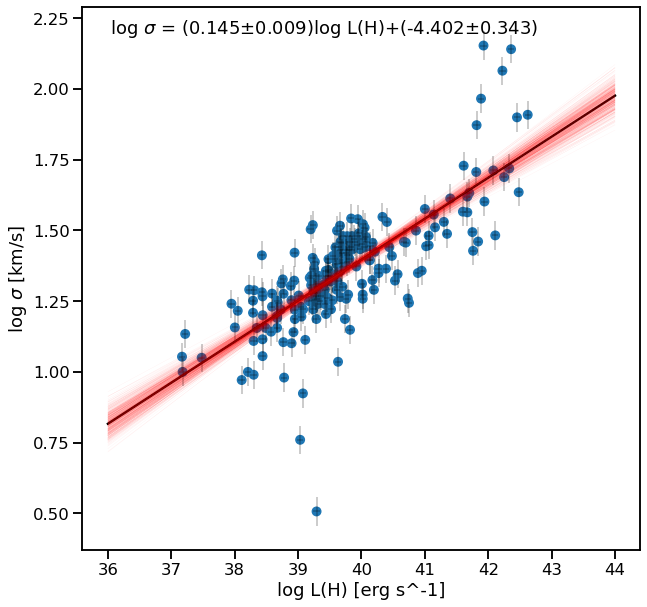

In [33]:
vmin, vmax = 36, 44
xgrid = np.linspace(vmin, vmax, 200)


fig, ax = plt.subplots(figsize=(10, 10))

ax.errorbar(X, Y, xerr=Xe, yerr=Ye, ls=" ", elinewidth=0.4, alpha=1.0, c="k")
ax.scatter(X, Y, marker=".", s=20/np.hypot(Xe, Ye))
# The original fit
ax.plot(xgrid, dfchain["alpha"].mean() + xgrid*dfchain["beta"].mean(), 
        '-', c="k")
for samp in lm.chain[::20]:
    ax.plot(xgrid, samp["alpha"] + xgrid*samp["beta"], 
        '-', c="r", alpha=0.2, lw=0.1)
    
ax.text(.05, .95,'log $\sigma$ = (' 
        + str(np.round(dfchain["beta"].mean(),3)) + '$\pm$' + str(np.round(dfchain["beta"].std(),3))
        + ')log L(H)+('
        + str(np.round(dfchain["alpha"].mean(),3)) + '$\pm$' + str(np.round(dfchain["alpha"].std(),3))
        + ')',  color='k', transform=ax.transAxes)
    
ax.set(
#    xlim=[-0.2, 0.8], ylim=[-0.2, 0.8],
    xlabel=r"log L(H) [erg s^-1]", ylabel=r"log $\sigma$ [km/s]",
)

In [34]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 48.08810639381409 seconds ---


In [35]:
!jupyter nbconvert --to script --no-prompt scaling-relations-catalogue.ipynb

[NbConvertApp] Converting notebook scaling-relations-catalogue.ipynb to script
[NbConvertApp] Writing 13364 bytes to scaling-relations-catalogue.py
